In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

In [76]:
# Cargar los datos
movies_df = pd.read_csv("data/movie_statistic_dataset.csv")

# Selección de columnas relevantes
relevant_columns = [
    "production_date",
    "genres",
    "runtime_minutes",
    # "director_name",
    "movie_averageRating",
    "movie_numberOfVotes",
    "approval_Index",
    "Production budget $",
    "Domestic gross $",
    "Worldwide gross $",
]
movies_df = movies_df[relevant_columns]

movies_df = movies_df.dropna()

movies_df["production_date"] = pd.to_datetime(movies_df["production_date"])


movies_df["production_year"] = movies_df["production_date"].dt.year
movies_df["production_month"] = movies_df["production_date"].dt.month
movies_df["production_day"] = movies_df["production_date"].dt.day

movies_df = movies_df.drop(columns=["production_date"])

# Split the 'genres' column into three separate columns
def split_genres(genres):
    genres_list = genres.split(",") if isinstance(genres, str) else []
    return pd.Series(genres_list[:3] + [None] * (3 - len(genres_list)))


movies_df[["genre_1", "genre_2", "genre_3"]] = movies_df["genres"].apply(split_genres)

# # Drop the original 'genres' column
movies_df = movies_df.drop(columns=["genres"])

# Separación de características y variable objetivo
X = movies_df.drop(columns=["Worldwide gross $"])
y = movies_df["Worldwide gross $"]

# Preprocesamiento de datos categóricos y numéricos
categorical_features = ["genre_1", "genre_2", "genre_3"]
numeric_features = [
    "runtime_minutes",
    "movie_averageRating",
    "movie_numberOfVotes",
    "approval_Index",
    "Production budget $",
    "Domestic gross $",
    "production_year",
    "production_month",
    "production_day",
]

# One-Hot Encoding for categorical features and Standard Scaling for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


pipeline = Pipeline(steps=[("preprocessor", preprocessor)])


X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

model = Sequential(
    [
        Dense(
            32,
            activation="relu",
            input_shape=(X_train_processed.shape[1],),
        ),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1),  # Capa de salida para regresión
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.004), loss="mean_absolute_error", metrics=["mae"]
)

history = model.fit(
    X_train_processed, y_train, epochs=100, batch_size=32, validation_split=0.2
)
loss, mae = model.evaluate(X_test_processed, y_test)
print(f"Mean Absolute Error on Test Set: {mae}")

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 114282776.0000 - mae: 114282776.0000 - val_loss: 105383008.0000 - val_mae: 105383008.0000
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 106948552.0000 - mae: 106948552.0000 - val_loss: 93870504.0000 - val_mae: 93870504.0000
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 89263968.0000 - mae: 89263968.0000 - val_loss: 64970384.0000 - val_mae: 64970384.0000
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 68919272.0000 - mae: 68919272.0000 - val_loss: 46735764.0000 - val_mae: 46735764.0000
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 51999100.0000 - mae: 51999100.0000 - val_loss: 39333516.0000 - val_mae: 39333516.0000
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 42664128.0000 - mae: 42664128.0000 - val_loss: 35160760.0000 - val_mae: 35160760.0000
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 40946136.0000 - mae: 40946136.0000 - val_loss: 32464720.0000 - va

In [77]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric, title=None):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    if title:
        plt.title(title)
    else:
        plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

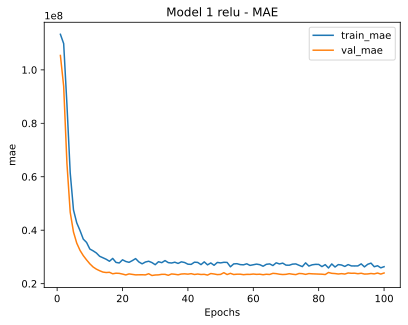

In [78]:
plot_metric(history, "mae", title="Model 1 relu - MAE")

In [79]:
# según Saturn cloud, aumentar el numero de capas es el primer paso para mejorar la exactitud (accuracy del modelo)
# https://saturncloud.io/blog/how-to-improve-accuracy-in-neural-networks-with-keras/
model2 = Sequential(
    [
        Dense(
            units=64,
            activation="relu",
            input_shape=(X_train_processed.shape[1],),
        ),
        Dropout(0.2),
        Dense(
            units=64,
            activation="relu"
        ),
        Dropout(0.2),
        Dense(
            units=64,
            activation="relu"
        ),
        Dropout(0.2),
        Dense(
            units=64,
            activation="relu"
        ),
        Dense(1),  # Capa de salida para regresión
    ]
)

model2.compile(
    optimizer=Adam(learning_rate=0.004), loss="mean_absolute_error", metrics=["mae"]
)

history = model2.fit(
    X_train_processed, y_train, epochs=100, batch_size=32, validation_split=0.2
)
loss, mae = model2.evaluate(X_test_processed, y_test)
print(f"Mean Absolute Error on Test Set: {mae}")

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 111988416.0000 - mae: 111988416.0000 - val_loss: 104316064.0000 - val_mae: 104316064.0000
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 100539912.0000 - mae: 100539912.0000 - val_loss: 72918272.0000 - val_mae: 72918272.0000
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 69753240.0000 - mae: 69753240.0000 - val_loss: 45086656.0000 - val_mae: 45086656.0000
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 47576824.0000 - mae: 47576824.0000 - val_loss: 36287780.0000 - val_mae: 36287780.0000
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 39285512.0000 - mae: 39285512.0000 - val_loss: 32001986.0000 - val_mae: 32001986.0000
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 39510500.0000 - mae: 39510500.0000 - val_loss: 29404070.0000 - val_mae: 29404070.0000
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 32894998.0000 - mae: 32894998.0000 - val_loss: 273291

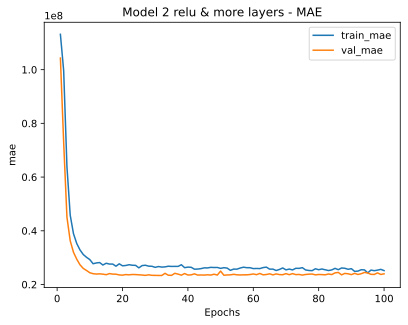

In [80]:
plot_metric(history, "mae", title="Model 2 relu & more layers - MAE")

In [81]:
# también según Saturn cloud, aumentar el numero de neuronas tambien aumenta la precision (accuracy) del modelo
# https://saturncloud.io/blog/how-to-improve-accuracy-in-neural-networks-with-keras/
model3 = Sequential(
    [
        Dense(
            units=128,
            activation="relu",
            input_shape=(X_train_processed.shape[1],),
            # input_dim=100,
        ),
        Dropout(0.2),
        Dense(
            units=64,
            activation="relu"
        ),
        Dropout(0.2),
        Dense(
            units=64,
            activation="relu"
        ),
        Dropout(0.2),
        Dense(
            units=64,
            activation="relu"
        ),
        Dense(1),  # Capa de salida para regresión
    ]
)

model3.compile(
    optimizer=Adam(learning_rate=0.004), loss="mean_absolute_error", metrics=["mae"]
)

history = model3.fit(
    X_train_processed, y_train, epochs=100, batch_size=32, validation_split=0.2
)
loss, mae = model3.evaluate(X_test_processed, y_test)
print(f"Mean Absolute Error on Test Set: {mae}")

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 119222136.0000 - mae: 119222136.0000 - val_loss: 103761440.0000 - val_mae: 103761440.0000
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 110133944.0000 - mae: 110133944.0000 - val_loss: 66047312.0000 - val_mae: 66047312.0000
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 69634128.0000 - mae: 69634128.0000 - val_loss: 41961792.0000 - val_mae: 41961792.0000
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 44005012.0000 - mae: 44005012.0000 - val_loss: 35006556.0000 - val_mae: 35006556.0000
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 37828956.0000 - mae: 37828956.0000 - val_loss: 31289346.0000 - val_mae: 31289346.0000
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 35145640.0000 - mae: 35145640.0000 - val_loss: 28851082.0000 - val_mae: 28851082.0000
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 32299748.0000 - mae: 32299748.0000 - val_loss: 268978

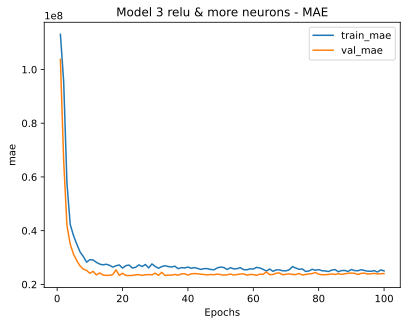

In [82]:
plot_metric(history, "mae", title="Model 3 relu & more neurons - MAE")

In [83]:
# Example of changing activation functions and increasing the number of neurons
model4 = Sequential(
    [
        Dense(
            units=256,  # Increased number of neurons
            activation="sigmoid",  # Changed activation function
            input_shape=(X_train_processed.shape[1],),
        ),
        Dropout(0.2),
        Dense(
            units=128,  # Increased number of neurons
            activation="relu"  # Changed activation function
        ),
        Dropout(0.2),
        Dense(
            units=128,  # Increased number of neurons
            activation="relu"  # Changed activation function
        ),
        Dropout(0.2),
        Dense(
            units=128,  # Increased number of neurons
            activation="relu"  # Changed activation function
        ),
        Dense(1),  # Output layer for regression
    ]
)

model4.compile(
    optimizer=Adam(learning_rate=0.004), loss="mean_absolute_error", metrics=["mae"]
)

history = model4.fit(
    X_train_processed, y_train, epochs=100, batch_size=32, validation_split=0.2
)
loss, mae = model4.evaluate(X_test_processed, y_test)
print(f"Mean Absolute Error on Test Set: {mae}")

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 117787936.0000 - mae: 117787936.0000 - val_loss: 99018320.0000 - val_mae: 99018320.0000
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101986200.0000 - mae: 101986200.0000 - val_loss: 73524200.0000 - val_mae: 73524200.0000
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77348328.0000 - mae: 77348328.0000 - val_loss: 53438436.0000 - val_mae: 53438436.0000
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55175188.0000 - mae: 55175188.0000 - val_loss: 43001588.0000 - val_mae: 43001588.0000
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50261612.0000 - mae: 50261612.0000 - val_loss: 38839752.0000 - val_mae: 38839752.0000
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39416640.0000 - mae: 39416640.0000 - val_loss: 36049324.0000 - val_mae: 36049324.0000
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37822664.0000 - mae: 37822664.0000 - val_loss: 33862340.0000 - val_

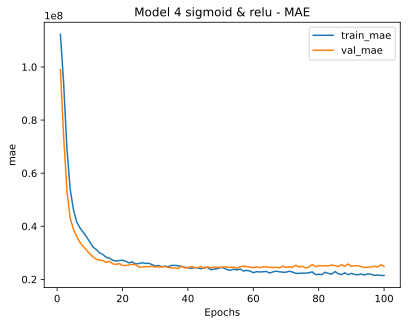

In [84]:
plot_metric(history, "mae", title="Model 4 sigmoid & relu - MAE")

In [85]:
# Example of changing activation functions and increasing the number of neurons
model5 = Sequential(
    [
        Dense(
            units=256,  # Increased number of neurons
            activation="elu",  # Changed activation function
            input_shape=(X_train_processed.shape[1],),
        ),
        Dropout(0.2),
        Dense(
            units=128,  # Increased number of neurons
            activation="relu"  # Changed activation function
        ),
        Dropout(0.2),
        Dense(
            units=128,  # Increased number of neurons
            activation="relu"  # Changed activation function
        ),
        Dropout(0.2),
        Dense(
            units=128,  # Increased number of neurons
            activation="relu"  # Changed activation function
        ),
        Dense(1),  # Output layer for regression
    ]
)

model5.compile(
    optimizer=Adam(learning_rate=0.004), loss="mean_absolute_error", metrics=["mae"]
)

history = model5.fit(
    X_train_processed, y_train, epochs=100, batch_size=32, validation_split=0.2
)
loss, mae = model5.evaluate(X_test_processed, y_test)
print(f"Mean Absolute Error on Test Set: {mae}")

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 108384976.0000 - mae: 108384976.0000 - val_loss: 91322792.0000 - val_mae: 91322792.0000
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86347264.0000 - mae: 86347264.0000 - val_loss: 45925592.0000 - val_mae: 45925592.0000
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46432376.0000 - mae: 46432376.0000 - val_loss: 34124656.0000 - val_mae: 34124656.0000
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34784260.0000 - mae: 34784260.0000 - val_loss: 28947986.0000 - val_mae: 28947986.0000
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33933744.0000 - mae: 33933744.0000 - val_loss: 26712362.0000 - val_mae: 26712362.0000
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29993276.0000 - mae: 29993276.0000 - val_loss: 24766426.0000 - val_mae: 24766426.0000
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27348732.0000 - mae: 27348732.0000 - val_loss: 24292756.0000 - val_ma

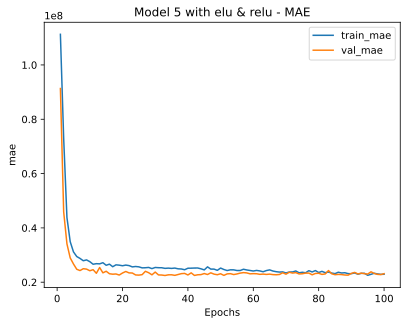

In [86]:
plot_metric(history, "mae", title="Model 5 with elu & relu - MAE")

In [87]:
# Example of changing activation functions and increasing the number of neurons
model6 = Sequential(
    [
        Dense(
            units=256,  # Increased number of neurons
            activation="elu",  # Changed activation function
            input_shape=(X_train_processed.shape[1],),
        ),
        Dropout(0.1),
        Dense(
            units=256,  # Increased number of neurons
            activation="relu"  # Changed activation function
        ),
        Dropout(0.2),
        Dense(
            units=128,  # Increased number of neurons
            activation="relu"  # Changed activation function
        ),
        Dropout(0.2),
        Dense(
            units=128,  # Increased number of neurons
            activation="relu"  # Changed activation function
        ),
        Dense(1),  # Output layer for regression
    ]
)

model6.compile(
    optimizer=Adam(learning_rate=0.004), loss="mean_absolute_error", metrics=["mae"]
)

history = model6.fit(
    X_train_processed, y_train, epochs=100, batch_size=32, validation_split=0.2
)
loss, mae = model6.evaluate(X_test_processed, y_test)
print(f"Mean Absolute Error on Test Set: {mae}")

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 109575792.0000 - mae: 109575792.0000 - val_loss: 84865144.0000 - val_mae: 84865144.0000
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75292360.0000 - mae: 75292360.0000 - val_loss: 41539636.0000 - val_mae: 41539636.0000
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39433656.0000 - mae: 39433656.0000 - val_loss: 31868878.0000 - val_mae: 31868878.0000
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34598644.0000 - mae: 34598644.0000 - val_loss: 27326298.0000 - val_mae: 27326298.0000
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29786352.0000 - mae: 29786352.0000 - val_loss: 25330444.0000 - val_mae: 25330444.0000
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28063424.0000 - mae: 28063424.0000 - val_loss: 24767838.0000 - val_mae: 24767838.0000
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28283184.0000 - mae: 28283184.0000 - val_loss: 23966800.0000 - val_ma

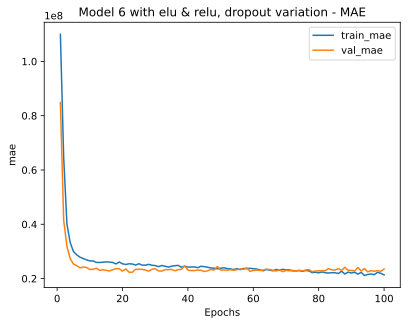

In [88]:
plot_metric(history, "mae", title="Model 6 with elu & relu, dropout variation - MAE")